In [1]:
import numpy as np
import re, copy
from scipy.stats import linregress
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

# read and write itp forcefield file

In [2]:
# read itp file

def get_atom_para(ff_dict, ff_para):
    
    atom_types   = dict([[i[0],i[-2:]] for i in ff_dict["atomtypes"]])
    atom_type   = [i[1] for i in ff_dict["atoms"]]
    atom_name   = [i[4] for i in ff_dict["atoms"]]
    vdw_para    = np.array([[atom_types[i[1]] for i in ff_dict["atoms"]]], dtype=np.float32).tolist()
    atom_charge = np.array([i[-2] for i in ff_dict["atoms"]], dtype=np.float32).tolist()
    atom_mass   = np.array([i[-1] for i in ff_dict["atoms"]], dtype=np.float32).tolist()
    
    ff_para["vdw_para"]    = vdw_para[0]
    ff_para["atom_name"]   = atom_name
    ff_para["atom_type"]   = atom_type
    ff_para["mass"]        = atom_mass
    ff_para["charge"]      = atom_charge
    ff_para["mol_name"]    = ff_dict["moleculetype"][0][0]
    
    tmp_pairs = ff_dict.get("pairs", [])
    if ff_dict["pairs"] != []:
        tmp_pairs = np.array(ff_dict["pairs"], dtype=np.int32)        
        ff_para["pairs"]["type"]   = tmp_pairs[:,2].tolist()
        ff_para["pairs"]["pair"]   = tmp_pairs[:,:2].tolist()
    
    
    exclusions = ff_dict.get("exclusions", [])
    if exclusions != []:
        exclusions = [[int(j)for j in i] for i in exclusions]    
        ff_para["exclusions"] = exclusions
    
    return(ff_para)

def get_bond_para(ff_dict, ff_para):
    
    bond_type = np.array([i[2]  for i in ff_dict["bonds"]], dtype=np.int32).tolist()
    bond_pair = np.array([i[:2] for i in ff_dict["bonds"]], dtype=np.int32).tolist()
    bond_para = np.array([i[3:] for i in ff_dict["bonds"]], dtype=np.float32).tolist()
    
    ff_para["bonds"]["type"] = bond_type
    ff_para["bonds"]["pair"] = bond_pair
    ff_para["bonds"]["para"] = bond_para
    
    
    return(ff_para)
    

def get_angle_para(ff_dict, ff_para):
    
    if ff_dict.get("angles", False) :
        angle_type = np.array([i[3]  for i in ff_dict["angles"]], dtype=np.int32).tolist()
        angle_pair = np.array([i[:3] for i in ff_dict["angles"]], dtype=np.int32).tolist()
        angle_para = np.array([i[4:] for i in ff_dict["angles"]], dtype=np.float32).tolist()


        ff_para["angles"]["type"] = angle_type
        ff_para["angles"]["pair"] = angle_pair
        ff_para["angles"]["para"] = angle_para
    
    return(ff_para)

def get_dihe_para(ff_dict, ff_para):
    
    if ff_dict.get("dihedrals", False) :

        tmp_order = ["1", "2", "3", "4", "6"]
        dihe_line = copy.deepcopy(ff_dict["dihedrals"])

        tmp_line = [i[:5] + [i[-1]]  for i in dihe_line if i[4]=="9"]

        for line in tmp_line:
            for i in tmp_order:
                if line[4] == "9" and not line[:5] +[i] in tmp_line :
                    dihe_line.append(line[:5] + ["0.0", "0.0"] +[i])
                    tmp_line.append(line[:5] + [i] )


        dihe_line = sorted(dihe_line, key=lambda x : " ".join(x[:5]+[x[-1]])) 


        dihe_type  = np.array([i[4]    for i in dihe_line if i[4]=="9" ], dtype=np.int32).tolist()
        dihe_pair  = np.array([i[:4]   for i in dihe_line if i[4]=="9" ], dtype=np.int32).tolist()
        dihe_para  = np.array([i[5:-1] for i in dihe_line if i[4]=="9" ], dtype=np.float32).tolist()
        dihe_order = np.array([i[-1]   for i in dihe_line if i[4]=="9" ], dtype=np.int32).tolist()

        impo_type  = np.array([i[4]    for i in dihe_line if i[4]!="9" ], dtype=np.int32).tolist()    
        impo_pair  = np.array([i[:4]   for i in dihe_line if i[4]!="9" ], dtype=np.int32).tolist()
        impo_para  = np.array([i[5:-1] for i in dihe_line if i[4]!="9" ], dtype=np.float32).tolist()
        impo_order = np.array([i[-1]   for i in dihe_line if i[4]!="9" ], dtype=np.int32).tolist() 

    
        ff_para["dihedrals"]["type"]  = dihe_type 
        ff_para["dihedrals"]["pair"]  = dihe_pair 
        ff_para["dihedrals"]["para"]  = dihe_para 
        ff_para["dihedrals"]["order"] = dihe_order

        ff_para["impropers"]["type"]  = impo_type 
        ff_para["impropers"]["pair"]  = impo_pair 
        ff_para["impropers"]["para"]  = impo_para 
        ff_para["impropers"]["order"] = impo_order
    

    return(ff_para)
 

def get_pos_restrain_para(ff_dict, ff_para):
    
    if ff_dict.get("position_restraints", False) :
        pos_restrain_line = copy.deepcopy(ff_dict["position_restraints"])

        atom_id  = [int(i[0]) for i in pos_restrain_line ]
        pos_type = [int(i[1]) for i in pos_restrain_line ]
        pos_para = [[flost(j) for j in i[2:]] for i in pos_restrain_line ]

        ff_dict["position_restraints"]["type"] = pos_type
        ff_dict["position_restraints"]["id"]   = atom_id 
        ff_dict["position_restraints"]["para"] = pos_para
    
    return(ff_dict)

def itp_read(itp_file, ff_type = "gaff"):
    
    itp_txt = open(itp_file, "r").read()
    itp_txt = re.sub(';.*', '' , itp_txt)
    itp_txt = re.sub('[\[\]]', '' , itp_txt)

    itp_line = itp_txt.split("\n")
    
    part_list = ["atomtypes", "moleculetype", "atoms","bonds","pairs","angles",
                 "dihedrals", "exclusions", "" ]
    
    ff_dict = {"atomtypes":[], "moleculetype":[], "atoms":[],     "bonds":[],
               "pairs":[],     "angles":[],       "dihedrals":[],  "exclusions":[], # "position_restraints":[]
              }
    
    addition_part = []
    for line in itp_line:
        line_split = line.split()
        
        if len(line_split) == 1 :
            part = line_split[0].lower()
        elif len(line_split) > 0 and part in part_list :
            ff_dict[part].append(line_split)
        elif len(line_split) > 0 and part not in part_list :
            addition_part.append(line)

    ff_para = {"vdw_para":[], "bonds":{}, "angles":{}, "dihedrals":{},
               "impropers":{}, "pairs":{}, "mol_name":"", "ff_type":"gaff","charge":[],"mass":[],
               "atom_type":[],"atom_name":[], "exclusions":[],
               "position_restraints":[]}
    
    ff_para["addition_part"] = addition_part

    ff_para = get_atom_para(ff_dict,  ff_para)
    ff_para = get_bond_para(ff_dict,  ff_para)
    ff_para = get_angle_para(ff_dict, ff_para)
    ff_para = get_dihe_para(ff_dict,  ff_para)
    #ff_para = get_pos_restrain_para(ff_dict, ff_para)
    ff_para["ff_type"] = ff_type
    
    return(ff_para)
    


# write itp file

def get_moleculetype_line(ff_para):
    
    moleculetype = [ "[ moleculetype ]",
                     " ;name            nrexcl",
                     "   %s              3" %(ff_para["mol_name"])]
    
    moleculetype = "\n".join(moleculetype)
    
    return(moleculetype)

def get_atomtypes_line(ff_para):
    
    atom_type   = ff_para["atom_type"]
    vdw_para    = ff_para["vdw_para"]

    
    txt = ["[ atomtypes ]",
           ";name   bond_type     mass     charge   ptype   sigma         epsilon       Amb"]
    
    
    for n in range(len(atom_type)):   
        tmp_line = " %5s %5s          0.000      0.000    A   %10.7f  %10.7f " %(atom_type[n], atom_type[n],
                                                                                  vdw_para[n][0], vdw_para[n][1])
        if not tmp_line in txt:
            txt.append(tmp_line)
        
    return(txt)
    

def get_atom_line(ff_para):
    
    atom_type   = ff_para["atom_type"]
    atom_name   = ff_para["atom_name"]
    atom_mass   = ff_para["mass"]
    atom_charge = ff_para["charge"]
    mol_title   = ff_para["mol_name"]
    
    txt = ["[ atoms ]",
           ";   nr   type  resi   res  atom  cgnr     charge      mass"]
    
    
    for n in range(len(ff_para["mass"])):        
        

        
        tmp_line = " %5d %5s %5d  %5s%5s %5d   %10.7f  %10.7f " %(n+1,atom_type[n], 1, mol_title, atom_name[n],
                                                                 n, atom_charge[n], atom_mass[n])
        txt.append(tmp_line)
        
    return("\n".join(txt))
    
   
    

def get_bond_line(ff_para):
    
    txt = ["[ bonds ]",
           " ;   ai   aj   funct     r          k"]

    if ff_para.get("bonds", {}) != {}:
        atom_name  = ff_para["atom_name"]
        bond_type  = ff_para["bonds"]["type"]
        bond_pair  = ff_para["bonds"]["pair"]
        bond_para  = ff_para["bonds"]["para"]       
    
        
        for n in range(len(bond_pair)):
            
            tmp_pair   = bond_pair[n]
            bond_atom  = "%s - %s" %(atom_name[tmp_pair[0] - 1], atom_name[tmp_pair[1] - 1])
            tmp_line = "  %4d %4d   %4d    %8.6f   %e  ; %s" %(tmp_pair[0], tmp_pair[1],bond_type[n],
                                                               bond_para[n][0], bond_para[n][1],
                                                               bond_atom)
            txt.append(tmp_line)

    return("\n".join(txt))
  
    

def get_angle_line(ff_para):
    
    
    txt = ["[ angles ]",
           ";   ai   aj  ak    funct    theta          cth"]

    if ff_para.get("angles", {}) != {}:
        atom_name   = ff_para["atom_name"]
        angle_type  = ff_para["angles"]["type"]
        angle_pair  = ff_para["angles"]["pair"]
        angle_para  = ff_para["angles"]["para"]


        for n in range(len(angle_type)):

            tmp_pair   = angle_pair[n]
            angle_atom = " - ".join([atom_name[i - 1] for i in tmp_pair])

            tmp_line = "  %4d %4d %4d %4d    %e   %e  ; %s" %tuple(tmp_pair + [angle_type[n]] +
                                                               angle_para[n] + [angle_atom])
            txt.append(tmp_line)
    return("\n".join(txt))
 
    

def get_dihe_line(ff_para):

    txt = ["[ dihedrals ] ; propers",
           ";    i   j    k    l   func     phase          kd         pn"]
    if ff_para.get("dihedrals", {}) != {}:
        atom_name  =  ff_para["atom_name"]
        dihe_type  =  ff_para["dihedrals"]["type"]  
        dihe_pair  =  ff_para["dihedrals"]["pair"]  
        dihe_para  =  ff_para["dihedrals"]["para"]  
        dihe_order =  ff_para["dihedrals"]["order"] 

        for n in range(len(dihe_order)):

            tmp_pair   = dihe_pair[n]
            dihe_atom = " - ".join([atom_name[i - 1] for i in tmp_pair])

            tmp_line = "  %4d %4d %4d %4d %4d   %e   %e  %d  ; %s" %tuple(tmp_pair + [dihe_type[n]] +
                                                                          dihe_para[n] + [dihe_order[n], dihe_atom])
            txt.append(tmp_line)
    
    return("\n".join(txt))

def get_impo_line(ff_para):
    
    txt = ["[ dihedrals ] ; impropers",
           ";    i   j    k    l   func     phase          kd         pn"]


    if ff_para.get("impropers", {}) != {}:
        atom_name  =  ff_para["atom_name"]
        impo_type  =  ff_para["impropers"]["type"]   
        impo_pair  =  ff_para["impropers"]["pair"]   
        impo_para  =  ff_para["impropers"]["para"]   
        impo_order =  ff_para["impropers"]["order"]  
        
       
        for n in range(len(impo_order)):
            
            tmp_pair   = impo_pair[n]
            impo_atom = " - ".join([atom_name[i - 1] for i in tmp_pair])
            
            tmp_line = "  %4d %4d %4d %4d %4d   %e   %e  %d  ; %s" %tuple(tmp_pair + [impo_type[n]] +
                                                                          impo_para[n] + [impo_order[n], impo_atom])
            txt.append(tmp_line)
    
    return("\n".join(txt))

def get_pairs_line(ff_para):

    txt = ["[ pairs ]",
           ";   ai     aj    funct "]

    if ff_para.get("pairs", {}) != {}:
        atom_name = ff_para["atom_name"]
        pair_type = ff_para["pairs"]["type"]
        pair_pair = ff_para["pairs"]["pair"]
        
    
        
        for n in range(len(pair_type)):
            
            tmp_pair   = pair_pair[n]
            pair_atom  = "%s - %s" %(atom_name[tmp_pair[0] - 1], atom_name[tmp_pair[1] - 1])
            tmp_line = "  %4d  %4d   %4d    ; %s" %(tmp_pair[0], tmp_pair[1], pair_type[n], pair_atom)
            txt.append(tmp_line)

    return("\n".join(txt))

def get_exclusions_line(ff_para):

    txt = ["[ exclusions ]",
          "; i  j"]

    if ff_para.get("exclusions", {}) != {}:
        exclusions = ff_para["exclusions"]
        exclusions = [[str(j)for j in i]for i in exclusions]    



        for i in exclusions:
            tmp_line = "  ".join(i)
            txt.append(tmp_line)
    
    return("\n".join(txt))
    

def get_pos_restraint_line(para):
    pos_restraint_line = ["[ position_restraints ]",
                          "; atom  type  fx    fy   fz"]
    for i in para:
       pos_restraint_line.append("  %d  %d   %f    %f    %f" %tuple(i)) 
    
    pos_restraint_str = "\n".join(pos_restraint_line)
    return(pos_restraint_str)

def get_itp_line(ff_para, pos_restraint = None, write_atomtypes = False):
    
    moleculetype_line = get_moleculetype_line(ff_para)
    atomtypes_line    = get_atomtypes_line(ff_para)    
    atom_line         = get_atom_line(ff_para)
    bond_line         = get_bond_line(ff_para)
    angle_line        = get_angle_line(ff_para)
    dihe_line         = get_dihe_line(ff_para)
    impo_line         = get_impo_line(ff_para)
    pairs_line        = get_pairs_line(ff_para)
    exclusions_line   = get_exclusions_line(ff_para)
    
    

    if pos_restraint:
        pos_restraint_line = get_pos_restraint_line(pos_restraint)
    else:
        pos_restraint_line = ""
    
    ff_type = ff_para.get("ff_type","gaff")
    if ff_type == "gaff" :
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        2          yes        0.5      0.8333"]
    elif ff_type == "opls":
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        3          yes        0.5      0.5"]
    
    default_line = "\n".join(default_line)
    atomtypes_line = "\n".join(atomtypes_line)

    addition_line = "\n".join(ff_para["addition_aprt"])
                    

    if write_atomtypes:
        itp_txt = [default_line      ,
                   moleculetype_line ,
                   atomtypes_line    ,
                   atom_line         ,
                   bond_line         ,
                   angle_line        ,
                   dihe_line         ,
                   impo_line         ,
                   pairs_line        ,
                   exclusions_line   ,
                   addition_line,     ]
    else:
        itp_txt = [moleculetype_line ,
                   atom_line         ,
                   pos_restraint_line,
                   bond_line         ,
                   angle_line        ,
                   dihe_line         ,
                   impo_line         ,
                   pairs_line        ,
                   exclusions_line   ,
                   addition_line,     ]
        
        
    itp_txt = "\n\n".join(itp_txt)
    
    return(itp_txt)

# write top file

def write_top(structure, ff_para_list, pos_restraint = None, write_itp = True):
    
    mol_types = structure.mol_types
    
    mol_list = [mol_types[0]]
    mol_num  = [1]
    for i in mol_types[1:]:
        if i == mol_list[-1]:
            mol_num[-1] = mol_num[-1] + 1
        else:
            mol_list.append(i)
            mol_num.append(1)
            
    
    ff_type = list(set([ff_para.get("ff_type","gaff") for ff_para in ff_para_list]))
    assert len(ff_type) == 1, "Forcefield types should be same."
    ff_type = ff_type[0]

    if ff_type == "gaff" :
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        2          yes        0.5      0.8333"]
    elif ff_type == "opls":
        default_line = ["[ defaults ]",
                    "  ;nbfunc  comb-rule  gen-pairs  fudgeLJ  fudgeQQ",
                    "    1        3          yes        0.5      0.5"]
    default_line = "\n".join(default_line)


    atomtypes_line = ["[ atomtypes  ]",
                      ";   nr   type  resi   res  atom  cgnr     charge      mass"]
    
    include_line = ["; Include itp topology file"]

    mol_restrant_list = list(pos_restraint.keys()) if pos_restraint else []
    for ff_para in ff_para_list:
        if pos_restraint and ff_para["mol_name"] in mol_restrant_list:            
            restraint_para = pos_restraint[ff_para["mol_name"]]
        else:
            restraint_para = None
        include_line.append('#include "%s.itp" '  %(ff_para["mol_name"]))
        itp_file = open("%s.itp" %(ff_para["mol_name"]), "w")
        itp_file.write(get_itp_line(ff_para, pos_restraint = restraint_para, write_atomtypes = False))
        itp_file.close()
        
        atomtypes_line = atomtypes_line + get_atomtypes_line(ff_para)[2:]
    
    atomtypes_line = "\n".join(atomtypes_line)
    include_line = "\n".join(include_line)
    
    system_line = ["[ system ]",
                   "system"     ] 
    
    system_line = "\n".join(system_line)
    
    molecules_line = ["[ molecules ]",
                      "; Compound        nmols", ]
    
        
    for mol_type, mol_num in zip(mol_list, mol_num )  :
        molecules_line.append("  %s              %d" %(mol_type, mol_num ))
    
        
    molecules_line = "\n".join(molecules_line)
    

    top_line = [default_line,
                atomtypes_line,
                include_line,
                system_line,
                molecules_line,

               ]

    top_line = "\n\n".join(top_line)
    
    topology_file = open("topol.top", "w")
    
    topology_file.write(top_line)
    topology_file.close()


# energy and parameter gradient calculation

In [25]:
# energy item calculation
def bond_feature(coord, bond_idx):
    bond_value = np.linalg.norm(coord[:, bond_idx[:,0]] - coord[:, bond_idx[:,1]], axis=-1)
    return(bond_value)

def angle_feature(coord, angle_idx):
    v1 = coord[:, angle_idx[:,0]] - coord[:, angle_idx[:,1]]
    v2 = coord[:, angle_idx[:,2]] - coord[:, angle_idx[:,1]]
    theta = np.arccos(np.sum(v1*v2, axis=-1) / (np.linalg.norm(v1, axis=-1) * np.linalg.norm(v2, axis=-1)))
    return(theta)

def dihedral_feature(coord, dihedral_idx):
    v1 = coord[:, dihedral_idx[:,1]] - coord[:, dihedral_idx[:,0]]
    v2 = coord[:, dihedral_idx[:,2]] - coord[:, dihedral_idx[:,1]]
    v3 = coord[:, dihedral_idx[:,3]] - coord[:, dihedral_idx[:,2]]
    v12 = np.cross(v1, v2, axis=-1)
    v23 = np.cross(v2, v3, axis=-1)

    vangle = np.arctan2(np.sum(v12*v3, axis=-1)*np.linalg.norm(v2,axis=-1), 
                        np.sum(v12*v23, axis=-1))
    return(vangle)

def improper_feature(coord, improper_idx):
    v1 = coord[:, improper_idx[:,1]] - coord[:, improper_idx[:,0]]
    v2 = coord[:, improper_idx[:,2]] - coord[:, improper_idx[:,1]]
    v3 = coord[:, improper_idx[:,3]] - coord[:, improper_idx[:,2]]
    v12 = np.cross(v1, v2, axis=-1)
    v23 = np.cross(v2, v3, axis=-1)

    vangle = np.arctan2(np.sum(v12*v3, axis=-1)*np.linalg.norm(v2,axis=-1), 
                        np.sum(v12*v23, axis=-1))
    return(vangle)

def nonbond_feature(coord, nonbond_idx, cutoff = 12.):
    # the default cutoff distance for nonbond is 12 A

    nonbond_dist = np.linalg.norm(coord[:, nonbond_idx[:,0]] - coord[:, nonbond_idx[:,1]], axis=-1)
    mask = np.logical_or(nonbond_dist > cutoff , nonbond_dist < 0.02)
    nonbond_dist[mask] = np.Inf
    return(nonbond_dist)

def get_feature(coord, ff, cutoff = 12.):
    
    # the index of bonded items start form 1
    bond_value      = bond_feature(coord,     np.array(ff["bonds"]["pair"])    -1)
    angle_value     = angle_feature(coord,    np.array(ff["angles"]["pair"])   -1)
    dihedral_value  = dihedral_feature(coord, np.array(ff["dihedrals"]["pair"])-1)
    improper_value  = improper_feature(coord, np.array(ff["impropers"]["pair"])-1)
    
    mol_atom_num = len(ff["charge"])
    nonbond_idx   = np.array([[i, j] for i in range(mol_atom_num) 
                                     for j in range(i, mol_atom_num)]) 
    
    nonbond_value = nonbond_feature(coord, nonbond_idx, cutoff = cutoff)    
    all_feature     = [bond_value, angle_value, dihedral_value, improper_value, nonbond_value]
    return(all_feature)

def get_ff_items(coord, ff, cutoff = 12.):

    all_feature    = get_feature(coord, ff, cutoff = cutoff)

    bond_value     = all_feature[0]
    angle_value    = all_feature[1]
    dihedral_value = all_feature[2]
    improper_value = all_feature[3]
    nonbond_value  = all_feature[4]

    # the unit of k is kj/mol/nm^2, the unit of b is nm, and the unit of bond_value is angstrom
    b = np.array(ff["bonds"]["para"])[:,0]
    bond_item = (bond_value / 10  - b)**2 / 2
    
    # the unit of k is kj/rad^2/mol, the unit of b is degree, and the unit of angle_value is radian
    b = np.array(ff["angles"]["para"])[:,0]
    angle_item = (angle_value - np.deg2rad(b))**2 / 2
    
    # the unit of k is kj/mol, the phase of b is degree, the unit of n is integer
    n     = np.array(ff["dihedrals"]["order"])
    phase = np.deg2rad(np.array(ff["dihedrals"]["para"])[:,0])
    dihedral_item  = 1 + np.cos( n * dihedral_value - phase )
    

    # the unit of k is kj/mol/rad^2, the unit of b is radian
    b = np.deg2rad(np.array(ff["impropers"]["para"])[:,0])
    improper_item = (np.abs(improper_value) - b)**2 / 2

    # the unit of nonbond distance is angstrom
    mol_atom_num = len(ff["charge"])
    
    # the bond pairs is the 1-2 pairs
    # the 1-3 pairs are the atoms connected by the center atoms in angle items
    # pair 1-4
    pair_14      = np.array(ff["pairs"]["pair"]) -1 
    # make sure the first atom index of the pair is larger then the second one
    mask = pair_14[:,0] > pair_14[:,1]
    pair_14[mask] = pair_14[mask][:,::-1]
    pair14_idx    = pair_14.tolist() 
    
    # pair 1-2, 1-3
    pair_1213    = np.array(ff["bonds"]["pair"] + [[i[0],i[2]] for i in ff["angles"]["pair"]]) - 1
    # make sure the first atom index of the pair is larger then the second one
    mask = pair_1213[:,0] > pair_1213[:,1]
    pair_1213[mask] = pair_1213[mask][:,::-1] 
    pair1213_idx    = pair_1213.tolist()
    mol_atom_num  = len(ff_itp['atom_name'])
    nonbond_idx   = np.array([[i, j] for i in range(mol_atom_num) 
                                     for j in range(i, mol_atom_num)])    
    vdw_coeffient = np.ones(len(nonbond_idx))
    coulomb_coeffient = np.ones(len(nonbond_idx))
    
    # the 1-4 scale coeffient
    n = 0
    for n, i in enumerate(nonbond_idx.tolist()) :
        if i in pair14_idx :
            vdw_coeffient[n] = 0.5
            coulomb_coeffient[n] = 0.833
        elif i in pair1213_idx :
            vdw_coeffient[n] = 0.0
            coulomb_coeffient[n] = 0.0   
        elif i[0] == i[1]:
            vdw_coeffient[n] = 0.0
            coulomb_coeffient[n] = 0.0 
            
#     print(np.sum(coulomb_coeffient>0))
    # intra-molecular
    # the unit of nonbond distance is angstrom
    r_1  = 1. / nonbond_value  
    r_6  = r_1**6 
    r_12 = r_6**2 
    
    r_1  = r_1  * coulomb_coeffient
    r_6  = r_6  * vdw_coeffient
    r_12 = r_12 * vdw_coeffient
    
    nonbond_item = np.array([r_1, r_6, r_12])
    all_item = [bond_item, angle_item, dihedral_item, improper_item, nonbond_item]

    return(all_item)

def get_energy_items(ff, all_item, e_qm, energy_only = False, weight_list = None):

    bond_item, angle_item, dihedral_item, improper_item, nonbond_item = all_item

    st_num       = len(nonbond_item)
    mol_atom_num = len(ff["charge"])
    e_total      = 0.
    
    
    # gradient of bonded item is the same with item's values here
    e_bond     = bond_item     * np.array(ff["bonds"]["para"]    )[:,1]
#     print(e_bond.reshape((1,-1))[0].sum())
    e_total   += np.sum(e_bond, axis=1)
    
    e_angle    = angle_item    * np.array(ff["angles"]["para"]   )[:,1]
#     print(e_angle.reshape((1,-1))[0].sum())
    e_total   += np.sum(e_angle, axis=1)
    
    e_dihedral = dihedral_item * np.array(ff["dihedrals"]["para"])[:,1]
#     print(e_dihedral.reshape((1,-1))[0].sum())
    e_total   += np.sum(e_dihedral, axis=1)
    
    e_improper = improper_item * np.array(ff["impropers"]["para"])[:,1]
#     print(e_improper.reshape((1,-1))[0].sum())
    e_total   += np.sum(e_improper, axis=1)
    
    del e_bond, e_angle, e_dihedral, e_improper

    charge  = np.array(ff["charge"])
    epsilon = np.array(ff["vdw_para"])[:, 1]
    sigma   = np.array(ff["vdw_para"])[:, 0]*10
    

    nonbond_idx = np.array([[i, j] for i in range(mol_atom_num) 
                                   for j in range(i,mol_atom_num)])
    e_coulomb   = charge[nonbond_idx[:,0]] * charge[nonbond_idx[:,1]] * nonbond_item[0] 
    e_coulomb   = e_coulomb * 27.2 * 96.485 * 0.5291772

    epsilon_mix = np.sqrt(epsilon[nonbond_idx[:,0]] * epsilon[nonbond_idx[:,1]]) 
    sigma_mix = (sigma[nonbond_idx[:,0]] + sigma[nonbond_idx[:,1]]) / 2
    all_r6 = sigma_mix**6 
    e_vdw  = 4 * epsilon_mix * (all_r6**2 * nonbond_item[2] - all_r6 * nonbond_item[1])
    
   
    # dE/dq_i = q_j / r_ij 
    #         = q_i*q_j/r_ij / q_i
    
    # dE/depsilon_i = 4*epsilon_ij * [(sigma_ij/r_ij)^12 - 6*(sigma_ij/r_ij)^6] / epsilon_i / 2
    #               = E_vdw / epsilon_i / 2
    
    # dE/dsigma = 4*epsilon_ij * [12*(sigma_ij/r_ij)^11 - 6*(sigma_ij/r_ij)^5]
    #           = 4*epsilon_ij * [12*(sigma_ij/r_ij)^12 - 6*(sigma_ij/r_ij)^6] / sigma_ij / 2
    g_vdw_sigma = 4 * epsilon_mix * (all_r6**2 * nonbond_item[2] * 12 - 
                                     all_r6    * nonbond_item[1] * 6 ) / sigma_mix
    
    
    e_total += np.sum(e_vdw, axis=1) + np.sum(e_coulomb, axis=1)
 
    
    if energy_only:
        return(e_total)
    
    if not isinstance(weight_list, np.ndarray):
        weight_list = np.ones(len(e_qm))
    assert len(e_qm) == len(weight_list), print("length of weight_list should be same with train set")
    
    
    # dE_MSD = 2(E_ff-E_qm)dE_ff/dk
    e_diff   = (e_total - e_total.mean()) - (e_qm - e_qm.mean())
    e_diff   = e_diff * weight_list
    e_diff   = e_diff.reshape((-1,1))


    g_bond     = np.sum(bond_item     * e_diff, axis=0)
    g_angle    = np.sum(angle_item    * e_diff, axis=0)
    g_dihedral = np.sum(dihedral_item * e_diff, axis=0)
    g_improper = np.sum(improper_item * e_diff, axis=0)
    
    g_charge   = np.zeros(mol_atom_num)
    g_epsilon  = np.zeros(mol_atom_num)
    g_sigma    = np.zeros(mol_atom_num)
    
    
    charge_mix  = e_coulomb   * e_diff
    e_vdw       = e_vdw       * e_diff
    g_vdw_sigma = g_vdw_sigma * e_diff
    for i in range(mol_atom_num):
        mask = nonbond_idx[:,0]==i
        g_charge[i]  += np.sum(charge_mix[:,mask] ) / charge[i]
        g_epsilon[i] += np.sum(e_vdw[:,mask]      ) / epsilon[i] 
        g_sigma[i]   += np.sum(g_vdw_sigma[:,mask])
        
        mask = nonbond_idx[:,1]==i
        g_charge[i]  += np.sum(charge_mix[:,mask] ) / charge[i]
        g_epsilon[i] += np.sum(e_vdw[:,mask]      ) / epsilon[i]
        g_sigma[i]   += np.sum(g_vdw_sigma[:,mask]) 

    g_epsilon = g_epsilon / 2 
    g_sigma   = g_sigma   / 2

    g_total = np.hstack([g_bond, g_angle, g_dihedral, g_improper, g_charge, g_epsilon, g_sigma])
    
    return(e_total, g_total)

def update_ff_parameter(ff_para, ff, ff_para_len, equivalent_item={}):

    # uodate forcefield parameters
    ff_new = copy.deepcopy(ff)
    
    # update forcefield parameters
    for n in range(ff_para_len[0], ff_para_len[1]):
        nn = n - ff_para_len[0]
        ff_new["bonds"]["para"][nn][1] = ff_para[n]   
    
    para_item = equivalent_item.get("bond", None)
    if para_item != None:
        for i in para_item:
            mean_value = ff_para[i].mean()
            for j in i:
                ff_new["bonds"]["para"][j][1] = mean_value       
        
        
    for n in range(ff_para_len[1], ff_para_len[2]):
        nn = n - ff_para_len[1]
        ff_new["angles"]["para"][nn][1] = ff_para[n]
        
    para_item = equivalent_item.get("angle", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i)+ff_para_len[1]
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["angles"]["para"][j][1] = mean_value 
        
        
    for n in range(ff_para_len[2], ff_para_len[3]):
        nn = n - ff_para_len[2]
        ff_new["dihedrals"]["para"][nn][1] = ff_para[n]
        
    para_item = equivalent_item.get("dihedral", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i)+ff_para_len[2]
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["dihedrals"]["para"][j][1] = mean_value 
        
        
    for n in range(ff_para_len[3], ff_para_len[4]):
        nn = n - ff_para_len[3]
        ff_new["impropers"]["para"][nn][1] = ff_para[n]
        
    para_item = equivalent_item.get("improper", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i)+ff_para_len[3]
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["impropers"]["para"][j][1] = mean_value 
        
        
    # coulomb
    new_charge = ff_para[ff_para_len[4]:ff_para_len[5]]
    # make sure the total net charge is zero
    new_charge   = new_charge - np.sum(new_charge)/len(new_charge)
    for n in range(len(new_charge)):
        ff_new["charge"][n] = new_charge[n] 
    
    para_item = equivalent_item.get("charge", None)
    if para_item != None:
        for i in para_item:
            mean_value = new_charge[i].mean()
            for j in i:
                ff_new["charge"][j] = mean_value 
  
    
    # vdw
    for n in range(ff_para_len[5], ff_para_len[6]):
        nn = n - ff_para_len[5]
        ff_new["vdw_para"][nn][1] = ff_para[n]
    for n in range(ff_para_len[6], ff_para_len[7]):
        nn = n - ff_para_len[6]
        ff_new["vdw_para"][nn][0] = ff_para[n]
        
    para_item = equivalent_item.get("epsilon", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i) + ff_para_len[5]            
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["vdw_para"][j][1] = mean_value
        
    para_item = equivalent_item.get("sigma", None)
    if para_item != None:
        for i in para_item:
            idx = np.array(i) + ff_para_len[6]            
            mean_value = ff_para[idx].mean()
            for j in i:
                ff_new["vdw_para"][j][0] = mean_value
        
    
    return(ff_new)

def set_equivalent_item(grad, ff_para_len, equivalent_item={}):
    
    # set the gradient value in equivalent_item to the average vaule
    
    if equivalent_item != None:
        
        parameter_list = ["bond", "angle", "dihedral", "improper", "charge",
                          "epsilon", "sigma"]
        # average the gradient value to the same
        for n, i in enumerate(parameter_list):        
            para_range = equivalent_item.get(i, None) 
            if para_range != None:
                for j in para_range:
                    idx = np.array(j)
                    grad[idx + ff_para_len[n]] = grad[idx + ff_para_len[n]].mean()
          
    
    return(grad)

def get_msd_gradient(ff_para, all_item, e_qm, ff, equivalent_item = {}, weight_list = None):
    
    k_bond     = np.array(ff["bonds"]["para"]    )[:,1]
    k_angle    = np.array(ff["angles"]["para"]   )[:,1]
    k_dihedral = np.array(ff["dihedrals"]["para"])[:,1]
    k_improper = np.array(ff["impropers"]["para"])[:,1]
    charge     = np.array(ff["charge"])
    epsilon    = np.array(ff["vdw_para"])[:, 1]
    sigma      = np.array(ff["vdw_para"])[:, 0]
    
    ff_para_len  = [0, len(k_bond), len(k_angle), len(k_dihedral), len(k_improper), len(charge), len(charge), len(charge)]
    ff_para_len  = np.cumsum(ff_para_len)
    
    # uodate forcefield parameters
    ff_new = update_ff_parameter(ff_para, ff, ff_para_len, equivalent_item=equivalent_item)    
    
    # total energy and gradient of forcefield parameters  
    e_total, g_total = get_energy_items(ff_new, all_item, e_qm, weight_list=weight_list)
    
    # set equivalent item 
    g_total = set_equivalent_item(g_total, ff_para_len, equivalent_item)    
    
    # msd
    e_total = e_total -e_total.mean()
    msd = np.sum((e_total - (e_qm- e_qm.mean()))**2 * weight_list)
    
    # fitting of ff energy and qm energy    
    fit = linregress(e_qm - e_qm.mean(), e_total)
    rmsd = (msd / len(e_total))**0.5
    print("y={:<6.4f}x+{:<6.4f}  rmsd={:<6.4f} r={:<6.4f}".format(fit.slope, fit.intercept, rmsd,
                                                                  fit.rvalue ))
    
    return(msd, g_total)

# forcefield optimizing

In [4]:
def get_parameter_range(parameter_range, ff_para, ff_para_len):
    
    # here default setting is 10% for bonded, vdw parameters, and 0.1 for charge 
    para_bond  =  np.array([ff_para*0.8, ff_para*1.2]).T
    para_bond[ff_para_len[4]:ff_para_len[5]][:,0] = ff_para[ff_para_len[4]:ff_para_len[5]] - 0.1
    para_bond[ff_para_len[4]:ff_para_len[5]][:,1] = ff_para[ff_para_len[4]:ff_para_len[5]] + 0.1
    if parameter_range != None:
        
        parameter_list = ["bond", "angle", "dihedral", "improper", "charge",
                          "epsilon", "sigma"]
        # update paramter range
        for n, i in enumerate(parameter_list):        
            para_range = parameter_range.get(i, None) 
            if para_range != None:
                for i in para_range.keys():
                    para_bond[i + ff_para_len[n]] = para_range[i]
                    
    return(para_bond)

def ff_opt_bfgs(ff, all_item, e_qm, parameter_range = None,
                     equivalent_item = {}, weight_list = None, cutoff = 12., maxcycle=50):
    
#     all_item = get_ff_items(coord_list, ff, cutoff = cutoff)
    
    if weight_list == None:
        weight_list = np.ones(len(e_qm))
    
    
    k_bond     = np.array(ff["bonds"]["para"]    )[:,1]
    k_angle    = np.array(ff["angles"]["para"]   )[:,1]
    k_dihedral = np.array(ff["dihedrals"]["para"])[:,1]
    k_improper = np.array(ff["impropers"]["para"])[:,1]
    charge     = np.array(ff["charge"])
    epsilon    = np.array(ff["vdw_para"])[:, 1]
    sigma      = np.array(ff["vdw_para"])[:, 0]
    
    ff_para    = np.hstack([k_bond, k_angle, k_dihedral, k_improper, charge, epsilon, sigma])
    ff_para_len  = [0, len(k_bond), len(k_angle), len(k_dihedral), len(k_improper), len(charge), 
                    len(charge), len(charge)]
    ff_para_len  = np.cumsum(ff_para_len)
        
    para_bound  =  get_parameter_range(parameter_range, ff_para, ff_para_len)
    
    
    ff_para_opt = fmin_l_bfgs_b(get_msd_gradient, ff_para, args=(all_item, e_qm, copy.deepcopy(ff), 
                                                                 equivalent_item, weight_list ), 
                                approx_grad=0, 
                                bounds=para_bound, m=10, factr=10000000.0, pgtol=1e-05, epsilon=1e-08, 
                                iprint=-1, maxfun=maxcycle, maxiter=1500)
    # updated ff parameter list
    ff_para_opt = ff_para_opt[0]
    
    # update ff parameters
    ff_new = update_ff_parameter(ff_para_opt, ff, ff_para_len, equivalent_item=equivalent_item)
    
    
    
    return(ff_new)

In [44]:
# load data
# the data comes from sgdml dataset(http://sgdml.org/), the molecula is Paracetamol
mol_data   = np.load("./testcase/paracetamol_dft.npz")
# load coordinate
coord_list = mol_data["R"]
# load energy
energy_qm  = mol_data["E"][:,0]*4.184
energy_qm = energy_qm - energy_qm.mean()

In [45]:
# read itp format gaff force field
# the forcefield was created by acpype on https://bio2byte.be/acpype/
ff_itp = itp_read("./testcase/mol.itp", ff_type = "gaff")

In [70]:
# parameter range setting
# This parameter is a dict, the items are the bond or nonbond parts in forcefield.
# There are "bond", "angle", "dihedral", "improper", "charge", "epsilon" or "sigma".
# The keys and items of the sub-dict items of those parts are the index of the specific bond 
# or nonbond parameters and the parameter ranges(which is a list, the lower and upper bound 
# of the paramters ). When some of the parts are not presented, default values will be used. 
# The details is in the function "get_parameter_range".
# If you want to fix some parameters of the forcefield, you can achive that by setting the lower 
# and upper bound of the specific paramter to the target value at same time.
# Below is a example. It may not be reasonable 
parameter_range = {"bond":{0:[ff_itp["bonds"]["para"][0][1] , 
                              ff_itp["bonds"]["para"][0][1]]},
                   
                   "charge":{5:[ff_itp["charge"][5] - 0.1,  
                                ff_itp["charge"][5] + 0.1]}}

# the equivalent item setting
# This parameter is a dict, and the items are the bond or nonbond parts in forcefield.
# There are "bond", "angle", "dihedral", "improper", "charge", "epsilon" or "sigma".
# The value of the sub-dict items is a list, and the elements of those lists is the index of 
# those specific bond or nonbond parameters which share a same value.
# Below is a example, and only for explaination, not for pratical forcefiled calculation.
equivalent_item   = {"bond":[[0, 1 ,2],
                             [3,4,5]],
                     
                     "charge": [[1,3,9]]}


# the weight setting
# The weight of every data in the train set, which decide the data point's contibution of 
# gradient to the total gradient. It is a list, and the default values is 1.0 for all
# data point in the train set.
weight_list = np.ones(len(coord_list))

In [23]:
# Use the mean of bond length and angle vaules of the data set to raplace the defualt
# value in the forcefield. This is a good idea usually.

mean_bond_length     = bond_feature(coord_list,     np.array(ff_itp["bonds"]["pair"])  -1)
mean_bond_length     = np.mean(mean_bond_length, axis=0)
mean_angle_value     = angle_feature(coord_list,    np.array(ff_itp["angles"]["pair"]) -1)
mean_angle_value     = np.mean(mean_angle_value, axis=0)

for n, i in enumerate(ff_itp["bonds"]["para"]):
    ff_itp["bonds"]["para"][n][0]  =  mean_bond_length[n] / 10
for n, i in enumerate(ff_itp["angles"]["para"]):
    ff_itp["angles"]["para"][n][0] =  np.rad2deg(mean_angle_value[n])

In [ ]:
# the test set index
train_set_idx = slice(0, 10000)

# ff_item, in which store the all items related to the covalent bond and
# noncovalent bond forcefield items computed from structure coordinates. So the energy
# and parameter gradient can be calculated effeciently during the following forcefield 
# optimizing procedure
ff_item  = get_ff_items(coord_list[train_set_idx], ff_itp)
# the ff_item can be saved as a npy file, so there is no need to calculate it everytimes when
# we want to optimize forcefield with a modified forcefield optimizing parameters
np.save("./ff_item_mol.npy", ff_item)

In [71]:
ff_opt = ff_opt_bfgs(ff_itp, ff_item, energy_qm[train_set_idx], 
                     parameter_range = parameter_range,
                     equivalent_item = equivalent_item, weight_list = None, maxcycle=500)

y=1.1102x+-0.0000  rmsd=18.9771 r=0.8419
y=1.0785x+0.0000  rmsd=33.7858 r=0.6445
y=1.1127x+-0.0000  rmsd=16.2818 r=0.8778
y=1.1123x+0.0000  rmsd=14.7720 r=0.8967
y=1.1117x+0.0000  rmsd=14.1421 r=0.9043
y=1.0963x+-0.0000  rmsd=13.0793 r=0.9140
y=1.0218x+0.0000  rmsd=12.0200 r=0.9134
y=1.0195x+-0.0000  rmsd=11.9972 r=0.9133
y=1.0206x+0.0000  rmsd=11.6446 r=0.9179
y=1.0150x+0.0000  rmsd=11.4464 r=0.9195
y=1.0094x+0.0000  rmsd=11.2094 r=0.9216
y=1.0088x+-0.0000  rmsd=11.0891 r=0.9230
y=1.0054x+0.0000  rmsd=10.8386 r=0.9256
y=1.0037x+0.0000  rmsd=10.7558 r=0.9264
y=1.0019x+0.0000  rmsd=10.6784 r=0.9271
y=1.0016x+-0.0000  rmsd=10.6594 r=0.9273
y=1.0000x+0.0000  rmsd=10.6236 r=0.9275
y=0.9988x+-0.0000  rmsd=10.6340 r=0.9272
y=0.9999x+0.0000  rmsd=10.6232 r=0.9275
y=0.9994x+0.0000  rmsd=10.6248 r=0.9274
y=0.9999x+0.0000  rmsd=10.6230 r=0.9275
y=0.9996x+0.0000  rmsd=10.6236 r=0.9274
y=0.9885x+-0.0000  rmsd=11.5664 r=0.9140
y=0.9995x+0.0000  rmsd=10.6237 r=0.9274
y=0.9996x+-0.0000  rmsd=10.6236 

y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0031x+-0.0000  rmsd=10.0122 r=0.9352
y=1.0029x+0.0000  rmsd=9.9810 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9808 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.0000  rmsd=9.9807 r=0.9355
y=1.0378x+-0.0000  rmsd=22.4304 r=0.7736
y=1.0030x+0.0000  rmsd=9.9809 r=0.9355
y=1.0029x+0.0000  rmsd=9.9808 r=0.9355
y=1.0029x+-0.0000  rmsd=9.9807 r=0.9355
y=1.0029x+0.

Text(0.5, 0, 'ff energy(kj/mol)')

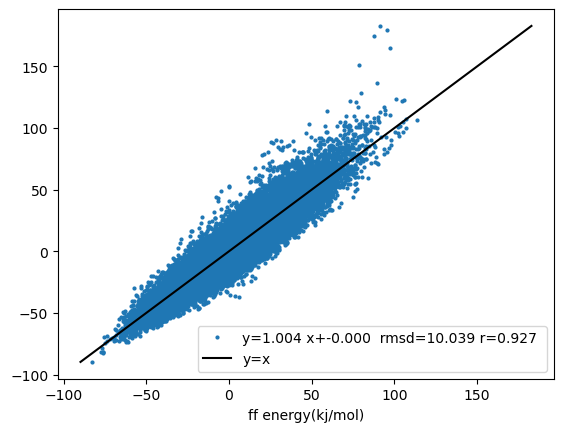

In [69]:
# the performance of the optimized forcefield on the other data poins in the dataset

test_set_idx = slice(10000, 50000)

all_item = get_ff_items(coord_list[test_set_idx], ff_opt)
e_ff ,_ = get_energy_items(ff_opt, all_item, energy_qm[test_set_idx])
e_ff = e_ff-e_ff.mean()

fit = linregress(energy_qm[test_set_idx]-energy_qm[test_set_idx].mean(), e_ff)
e_diff = energy_qm[test_set_idx]- e_ff
rmsd   = np.mean(e_diff**2)**0.5
label="y={:<6.3f}x+{:<6.3f}  rmsd={:<6.3f} r={:<6.3f}".format(fit.slope, fit.intercept, rmsd,
                                                                  fit.rvalue )
plt.plot(energy_qm[test_set_idx],e_ff-e_ff.mean(), marker="o", markersize=2, 
         linewidth=0, label=label )
plt.plot([e_ff.min(),e_ff.max()],[e_ff.min(),e_ff.max()], label="y=x", color="k")
plt.legend()
plt.xlabel("qm energy(kj/mol)")
plt.xlabel("ff energy(kj/mol)")

<BarContainer object of 59 artists>

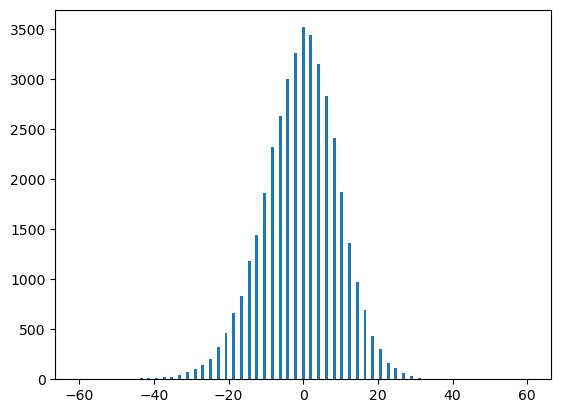

In [76]:
# the energy difference distribution of test set
bins = np.linspace(-60,60, 60)
num, bins = np.histogram(e_diff, bins=bins )
plt.bar(np.linspace(-60,60, 59), num)

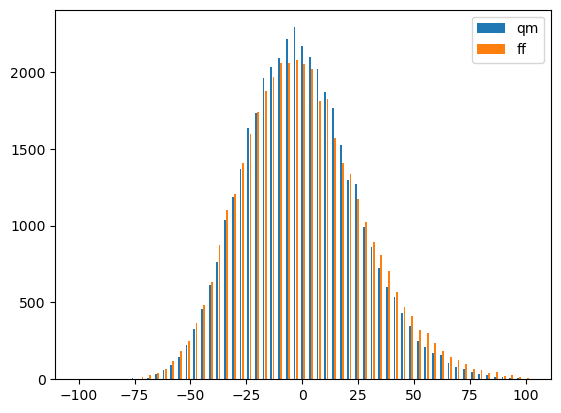

In [77]:
# the energy distribution of test set

bins = np.linspace(-100,100, 60)
num, bins = np.histogram(energy_qm[test_set_idx], bins=bins )
plt.bar(np.linspace(-100,100, 59), num, label="qm")
bins = np.linspace(-100,100, 60)
num, bins = np.histogram(e_ff, bins=bins )
plt.bar(np.linspace(-100,100, 59)+1, num, label="ff")
plt.legend()